<a href="https://colab.research.google.com/github/shahriarshayesteh/CPSC_540_NLP_Project/blob/master/(self_attention%5Ccross_attention%20)Visualize_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# What is Attention?

In [1]:
!pip install bertviz


import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses

from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.datasets import fetch_20newsgroups
from gensim.utils import simple_preprocess
import numpy as np

## Prepare Text Data

In [2]:
newsgroups_train = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))
data = pd.DataFrame({"text":newsgroups_train.data, "target":newsgroups_train.target})
data.text = [" ".join(simple_preprocess(doc, min_len=2)) for doc in data.text]
data_clean = data[(data.text!="") & (~data.text.str.isspace())] 
data_clean.reset_index(inplace=True, drop=True)
newsgroups = [newsgroups_train.target_names[i] for i in data_clean.target]
data_clean["newsgroup"] = newsgroups

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [3]:
data_clean.head()

,text,target,newsgroup
0,am sure some bashers of pens fans are pretty c...,10,rec.sport.hockey
1,my brother is in the market for high performan...,3,comp.sys.ibm.pc.hardware
2,finally you said what you dream about mediterr...,17,talk.politics.mideast
3,think it the scsi card doing the dma transfers...,3,comp.sys.ibm.pc.hardware
4,have an old jasmine drive which cannot use wit...,4,comp.sys.mac.hardware


## Vectorize Text Data

In [4]:
# vectorize text
vocab_size = 10000
maxlen = 50

vectorize_layer = layers.TextVectorization(
    max_tokens=vocab_size,
    output_sequence_length=maxlen,
    output_mode='int')

vectorize_layer.adapt(data_clean.text.tolist())

In [5]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
x_train, x_val, y_train, y_val = train_test_split(data_clean.text.tolist(), 
                                                    data_clean.target.tolist(), 
                                                    test_size=0.2, 
                                                    stratify=data_clean.target.tolist())


In [7]:

x_train = vectorize_layer(tf.expand_dims(x_train, -1))
x_val = vectorize_layer(tf.expand_dims(x_val, -1))

y_train = np.array(y_train)
y_val = np.array(y_val)

In [8]:
x_train

<tf.Tensor: shape=(14647, 50), dtype=int64, numpy=
array([[  13,  722, 3416, ...,  844,    8,    3],
       [1449,    9,    2, ...,    2, 3470,    0],
       [   1,    1, 1371, ...,    5,    1,  235],
       ...,
       [4644,    1,  257, ...,    0,    0,    0],
       [  57,   73,    2, ...,    0,    0,    0],
       [ 316,    1,    1, ..., 5120,    1, 7656]])>

## Embedding Layer

### GloVe

In [9]:
voc = vectorize_layer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [10]:
path_to_glove_file = "/content/drive/MyDrive/pre-trained_embeddings/glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [11]:
num_tokens = len(voc) + 2
embedding_dim = 100
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 9751 words (249 misses)


## Neural Network Architecture

Attention:

https://keras.io/api/layers/attention_layers/multi_head_attention/
https://www.tensorflow.org/addons/api_docs/python/tfa/layers/MultiHeadAttention

Transformer: 

https://keras.io/examples/nlp/text_classification_with_transformer/

https://www.tensorflow.org/text/tutorials/transformer

Transformer Translation:

https://www.tensorflow.org/text/tutorials/nmt_with_attention

Analysis Ideas:

- use pre-trained embeddings to focus on attention 
- explore difference in attention with and without positional embeddings
- study attention patterns to understand classification
- try visualizing contextualized embeddings

To-do:

1. Creating USE embedding layer
2. Creating positional encoding layer with formula based embedding
3. Visualzing attention weights from trained model
4. Visualizizing embeddings pre and post attention

In [12]:
class AttentionModel(tf.keras.Model):

    def __init__(self, vocab_size, embedding_dim):
        super(AttentionModel, self).__init__()
        
        # self.embedding = layers.Embedding(vocab_size + 1, embedding_dim)
        self.embedding = layers.Embedding(vocab_size,
                                        embedding_dim,
                                        embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                                        trainable=False,
                                    )

        self.attention = layers.MultiHeadAttention(num_heads=4, key_dim=100)
        self.pooling = layers.GlobalAveragePooling1D()
        self.dense = layers.Dense(20, activation="softmax")
        
        self.dropout1 = layers.Dropout(0.1)
        self.dropout2 = layers.Dropout(0.1)
        self.layernorm = layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs, training):
        
        token_embeddings = self.embedding(inputs)
        contextualized_embeddings = self.attention(token_embeddings, token_embeddings)
        
        contextualized_embeddings = self.dropout1(contextualized_embeddings, training=training)
        contextualized_embeddings = self.layernorm(contextualized_embeddings)
        
        combined_embedding = self.pooling(contextualized_embeddings)
        
        combined_embedding = self.dropout2(combined_embedding)
        
        output = self.dense(combined_embedding)
        
        return output

In [13]:
# model = AttentionModel(vocab_size=vocab_size, embedding_dim=50)
model = AttentionModel(vocab_size=num_tokens, embedding_dim=100)

In [14]:
model.compile(optimizer="adam",
              loss=losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=["accuracy"])

In [15]:
model.build(x_train.shape)

In [16]:
model.summary()

Model: "attention_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  1000200   
                                                                 
 multi_head_attention (Multi  multiple                 161300    
 HeadAttention)                                                  
                                                                 
 global_average_pooling1d (G  multiple                 0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               multiple                  2020      
                                                                 
 dropout (Dropout)           multiple                  0         
                                                                 
 dropout_1 (Dropout)         multiple              

In [17]:
history = model.fit(x_train,
                    y_train,
                    epochs=10,
                    validation_data=(x_val, y_val)
)

Epoch 1/10
458/458 [==============================] - 6s 5ms/step - loss: 1.6826 - accuracy: 0.4840 - val_loss: 1.4282 - val_accuracy: 0.5710
Epoch 2/10
458/458 [==============================] - 2s 5ms/step - loss: 1.3112 - accuracy: 0.5979 - val_loss: 1.3003 - val_accuracy: 0.5999
Epoch 3/10
458/458 [==============================] - 2s 5ms/step - loss: 1.2166 - accuracy: 0.6233 - val_loss: 1.3133 - val_accuracy: 0.6024
Epoch 4/10
458/458 [==============================] - 2s 5ms/step - loss: 1.1621 - accuracy: 0.6401 - val_loss: 1.3012 - val_accuracy: 0.6084
Epoch 5/10
458/458 [==============================] - 2s 5ms/step - loss: 1.1145 - accuracy: 0.6512 - val_loss: 1.3027 - val_accuracy: 0.6051
Epoch 6/10
458/458 [==============================] - 2s 5ms/step - loss: 1.0873 - accuracy: 0.6590 - val_loss: 1.2451 - val_accuracy: 0.6240
Epoch 7/10
458/458 [==============================] - 2s 5ms/step - loss: 1.0510 - accuracy: 0.6679 - val_loss: 1.2871 - val_accuracy: 0.6191
Epoch 

Visualizing Attention

https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

In [107]:
import matplotlib.ticker as ticker
from matplotlib.ticker import MaxNLocator


'''
visualize attension layer for the given input text (self attention or attention between two sentences) using matplotlib
'''

class Attension_visulaizer():


  def __init__(self,model):
    self.model = model

  #get model layer by index
  def get_model_layer(self, idx):

     return self.model.get_layer(index=idx)

  #turn text to number
  def vectorize(self,sentence):

    return vectorize_layer(sentence)

  #tokenize the text and add sepcial tokens 
  def tokenizer(self,sentence):

    vectorized_text = vectorize_layer(sentence)
    # print("vectorized_text",vectorized_text)
    actual_text = [key_list[ind] for ind in vectorized_text if key_list[ind]!=""]
    # print("actual_text",actual_text)
    return actual_text

 #get the output of a sentence from embedding layer 
  def embedding(self,sentence):

    # we just want to visualzie non-padding elements
    non_zero = len(self.tokenizer(sentence))

    embedding_layer = self.get_model_layer(0)
    embedded_text =  embedding_layer(self.vectorize(sentence)[:non_zero])
    return tf.expand_dims(embedded_text, axis=0)

  def attention(self, sentence1, sentence2):

    trained_attention_layer = self.get_model_layer(1)
    
    embedded_text1 = self.embedding(sentence1)
    embedded_text2 = self.embedding(sentence2)

    print("embedded_text1",embedded_text1.shape)
    print("embedded_text2",embedded_text2.shape)


    output_tensor, attn_weights = trained_attention_layer(embedded_text1, embedded_text2, return_attention_scores=True)

    return output_tensor,attn_weights

  @staticmethod
  def attention_numpy(attn_weights ):

    return attn_weights.numpy()


  @staticmethod
  def attention_torch(attn_weights ):

    return torch.tensor(Attension_visulaizer.attention_numpy(attn_weights ))


  
  def evaluateAndShowAttention(self,sentence1, sentence2 =None, attension_heads = None):

    if sentence2 == None:
      sentence2 = sentence1

    #computing the attention weights between two sentences *** we discart the attension weights if sentence length is less than max_len***
    print("sentence1",len(sentence1))  
    output_tensor,attn_weights = self.attention(sentence1,sentence2)
    print("output_tensor",output_tensor.shape)  

    tkn_sen1 = self.tokenizer(sentence1)
    tkn_sen2 = self.tokenizer(sentence2)

    #attention weights for visualization should be in numpy
    attentions_numpy = Attension_visulaizer.attention_numpy(attn_weights)

    print("attn_weights",attn_weights.shape)
    
    # just squeez the first dimension to plot it using showAttention function
    attentions_numpy1 = attentions_numpy.transpose((0, 2,3,1))[0,:,:,:]

    self.showAttention(tkn_sen1, tkn_sen2, attentions_numpy1,attension_heads)

    self.attention_head(attentions_numpy,tkn_sen1)

    self.head_view(attentions_numpy,tkn_sen1)

    # return  output_tensor,attn_weights

  def showAttention(self,input_sentence, output_words, attentions,attension_heads = None):

    if attension_heads != None:

      w = attentions[:,:,attension_heads]
      plt_range = 1


    else:

       w = attentions
       plt_range = w.shape[2]
    
    print(w[1].shape)
    fig, axes = plt.subplots(nrows = 4, ncols = 1, figsize = (2*len(input_sentence), 2*len(output_words)), facecolor = "w")

    for i in range(plt_range):
      print(i)
      axes[i].imshow(w[:,:,i])
      axes[i].set_yticks(np.arange(len(input_sentence)))
      axes[i].set_yticklabels(input_sentence)
      axes[i].set_xticks(np.arange(len(input_sentence)))
      axes[i].set_xticklabels(input_sentence)
      plt.setp(axes[i].get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")
      
    plt.show()

  from bertviz import head_view
 
  def attention_head(self,attention_w,actual_text):
    attension_heads = []
    attention = torch.tensor(attention_w)

    for i in range(attention.shape[1]):

      attension_heads.append(attention[:,i:i+1,:,:])

    # attension_heads = (attention[:,0:1,:,:],attention[:,1:2,:,:],attention[:,2:3,:,:],attention[:,3:4,:,:])
    attension_heads = tuple(attension_heads)

    # print("8888888888",attension_heads)

    # different_heads but this function is for different layer

    head_view(attension_heads, actual_text)

  
  def head_view(self,attention_w,actual_text):

    attention = torch.tensor(attention_w)

    head_view((attention,), actual_text)


In [108]:
import random

def randomized_text(x_train):
  # Random Example Text
  vectorized_text = x_train[random.randint(0,x_train.shape[0])]
  print("vectorized_text",vectorized_text)

  key_list = list(word_index.keys())
  actual_text = [key_list[ind] for ind in vectorized_text]
  text = " ".join(actual_text)
  print(text)

  return text

text = randomized_text(x_train)

vectorized_text tf.Tensor(
[1265   16  129   17   13  357   30  412    9  191   28  164   49   17
   10  106  711   26    2  634  656  116 5529   33 3105   16  178   73
  759   22  617  116 4090  440  457   24  279  648   24    2  503    5
    2  965    1    2  397 1786    3 4642], shape=(50,), dtype=int64)
hello have problem with on sun an hope that someone can help me with it ve built from the mit sources after applying all patches have got think building was easy after installing everything started but nothing happened but the screen and the keyboard [UNK] the machine seemed to hang


sentence1 283
embedded_text1 (1, 50, 100)
embedded_text2 (1, 50, 100)
output_tensor (1, 50, 100)
attn_weights (1, 4, 50, 50)
(50, 4)
0
1
2
3


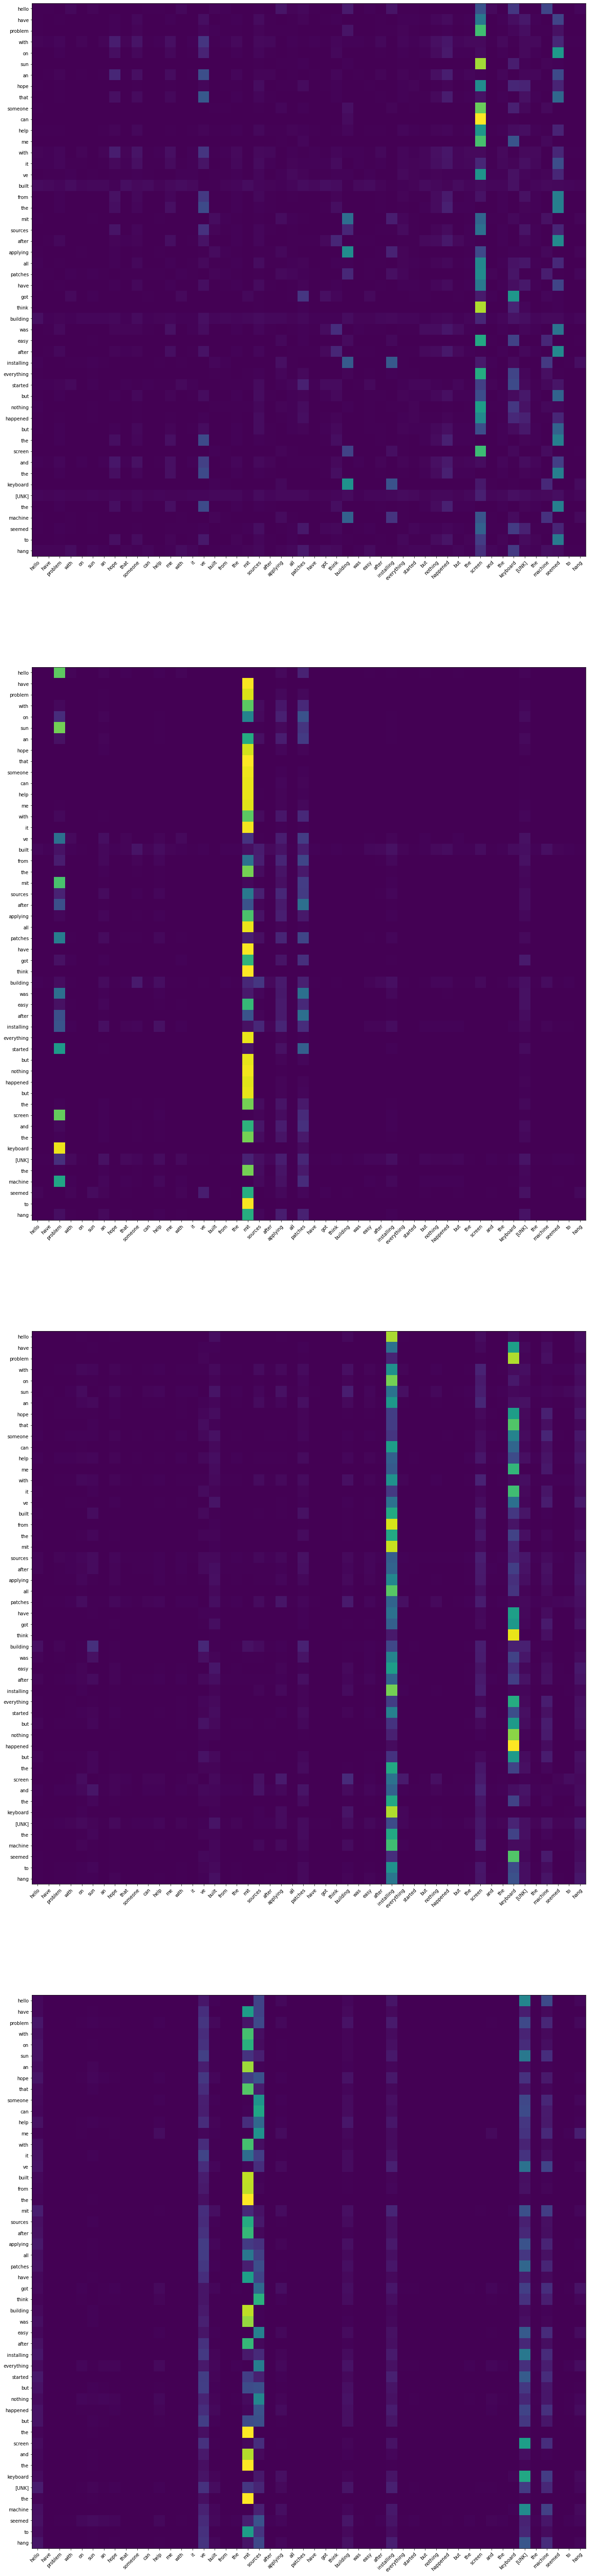

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [109]:
import matplotlib.pyplot as plt
#https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html
vis = Attension_visulaizer(model)
actual_text = text
vis.evaluateAndShowAttention(actual_text, attension_heads = None)

In [ ]:
'''
Next: embedding visualization
'''

'\nNext: embedding visualization\n'

In [ ]:
emb = model.get_layer(index=0)
vectorize_layer.get_vocabulary()
emb

In [ ]:
emb(vectorize_layer('car'))

<tf.Tensor: shape=(50, 100), dtype=float32, numpy=
array([[-0.1684 , -0.53827,  0.31155, ...,  0.39684,  1.734  , -0.70787],
       [ 0.     ,  0.     ,  0.     , ...,  0.     ,  0.     ,  0.     ],
       [ 0.     ,  0.     ,  0.     , ...,  0.     ,  0.     ,  0.     ],
       ...,
       [ 0.     ,  0.     ,  0.     , ...,  0.     ,  0.     ,  0.     ],
       [ 0.     ,  0.     ,  0.     , ...,  0.     ,  0.     ,  0.     ],
       [ 0.     ,  0.     ,  0.     , ...,  0.     ,  0.     ,  0.     ]],
      dtype=float32)>

In [ ]:
# import pandas as pd
# pd.options.mode.chained_assignment = None 
# import numpy as np
# import re
# import nltk

# from gensim.models import word2vec

# from sklearn.manifold import TSNE
# import matplotlib.pyplot as plt
# %matplotlib inline


# labels = []
# tokens = []

# for word in vectorize_layer.get_vocabulary():
#     non_zero = len(tokenizer("word"))
#     tokens.append(emb(vectorize_layer(word)[:non_zero]).numpy())
#     labels.append(word)

# tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
# new_values = tsne_model.fit_transform(tokens)

# x = []
# y = []
# for value in new_values:
#     x.append(value[0])
#     y.append(value[1])
    
# plt.figure(figsize=(16, 16)) 
# for i in range(len(x)):
#     plt.scatter(x[i],y[i])
#     plt.annotate(labels[i],
#                   xy=(x[i], y[i]),
#                   xytext=(5, 2),
#                   textcoords='offset points',
#                   ha='right',
#                   va='bottom')
# plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


ValueError: ignored

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


(10000,)

In [ ]:
def tokenizer(sentence):

    vectorized_text = vectorize_layer(sentence)
    # print("vectorized_text",vectorized_text)
    actual_text = [key_list[ind] for ind in vectorized_text if key_list[ind]!=""]
    # print("actual_text",actual_text)
    return actual_text

In [ ]:
non_zero = len(tokenizer("word"))
emb(vectorize_layer("word")[:non_zero]).numpy()

array([[ 0.1233  ,  0.55741 ,  0.74203 , -0.06547 , -0.33485 ,  0.81541 ,
        -0.16384 , -1.0327  ,  0.41834 , -0.012764, -0.60695 ,  0.30146 ,
         0.35976 ,  0.41161 ,  0.03381 , -0.091115,  0.35077 , -0.24798 ,
        -0.13128 ,  0.19869 ,  0.046961,  0.014633, -0.39851 , -0.11829 ,
        -0.27432 , -0.032518, -0.23637 , -0.072372, -0.04237 , -0.11159 ,
         0.12129 ,  0.64011 , -0.50275 , -0.21584 ,  0.30097 , -0.041772,
        -0.47972 , -0.12897 ,  0.6964  , -0.27594 , -0.29149 ,  0.088033,
         0.12874 , -0.15249 , -0.20548 ,  0.029435,  0.055133, -0.12994 ,
        -0.33869 , -0.61891 ,  0.4743  ,  0.60288 ,  1.0209  ,  0.48663 ,
        -1.0587  , -1.9711  , -0.41751 ,  0.12457 ,  1.304   ,  0.26925 ,
         0.28003 ,  0.91141 , -0.62217 , -0.70356 ,  1.0379  , -0.095316,
         0.54085 , -0.36123 , -0.10311 , -0.31059 , -0.61454 ,  0.63799 ,
         0.18329 , -0.49599 ,  0.3607  ,  0.70414 , -0.28096 ,  0.1062  ,
        -0.64866 , -0.28698 , -0.26623

[Positional encoding
](https://www.tensorflow.org/text/tutorials/transformer#positional_encoding)

Attention layers see their input as a set of vectors, with no sequential order. This model also doesn't contain any recurrent or convolutional layers. Because of this a "positional encoding" is added to give the model some information about the relative position of the tokens in the sentence.

The positional encoding vector is added to the embedding vector. Embeddings represent a token in a d-dimensional space where tokens with similar meaning will be closer to each other. But the embeddings do not encode the relative position of tokens in a sentence. So after adding the positional encoding, tokens will be closer to each other based on the similarity of their meaning and their position in the sentence, in the d-dimensional space.

The formula for calculating the positional encoding is as follows:



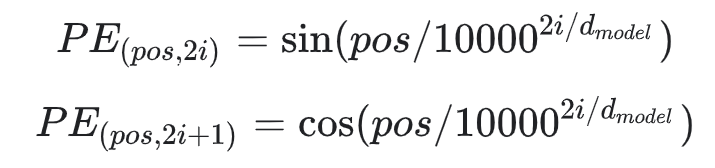

In [ ]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates



def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  pos_encoding = angle_rads[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32)

(1, 2048, 512)


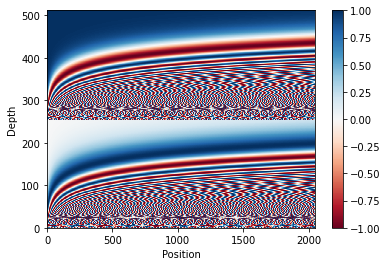

In [ ]:
n, d = 2048, 512
pos_encoding = positional_encoding(n, d)
print(pos_encoding.shape)
pos_encoding = pos_encoding[0]

# Juggle the dimensions for the plot
pos_encoding = tf.reshape(pos_encoding, (n, d//2, 2))
pos_encoding = tf.transpose(pos_encoding, (2, 1, 0))
pos_encoding = tf.reshape(pos_encoding, (d, n))

plt.pcolormesh(pos_encoding, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()